####Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Statistics
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
    VotingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


**About Dataset**

The data set has 17 columns and 1000 rows. Columns are described below and each row is a customer.

1. checking_balance : Amount of money available in account of customers
2. months_loan_duration : Duration since loan taken
3. credit_history : credit history of each customers
4. purpose : Purpose why loan has been taken
5. amount : Amount of loan taken
6. savings_balance : Balance in account
7. employment_duration : Duration of employment
8. percent_of_income : Percentage of monthly income
9. years_at_residence : Duration of current residence
10. age : Age of customer
11. other_credit : Any other credits taken
12. housing : Type of housing, rent or own
13. existing_loans_count : Existing count of loans
14. job : Job type
15. dependents : Any dependents on customer
16. phone : Having phone or not
17. default : Default status (Target column)



### Functions Used for Data Manipulation, Processing and Modeling

In [ ]:
# Visualization : Feature Distribution
def feature_distribution(df, features):
    # Calculate the number of rows and columns needed for subplots
    num_rows = (len(features) + 1) // 2
    num_cols = 2

    # Create a figure and subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 30))

    # Flatten the axs array to iterate through subplots
    axs = axs.flatten()

    # Iterate through features and create bar plots
    for i, feature in enumerate(features):
        ax = axs[i]
        df[feature].value_counts().plot(kind='bar', ax=ax)
        ax.set_title(f'{feature} Distribution')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Visualization: Relationship between Categorical Predictor Columns to the target.
def categorical_predictors_to_target(df, categorical_columns):
    plt.figure(figsize=(15, 10))
    for col in categorical_columns:
        plt.subplot(3, 3, categorical_columns.index(col) + 1)
        sns.countplot(x=col, hue='default', data=df)
        plt.title(f'Relationship between {col} and Default')
        plt.ylabel('Default')
        plt.xlabel(col)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Visualization: Relationship between Numerical Predictor Columns to the target.
def numeric_predictors_to_target(df, numeric_columns):
    plt.figure(figsize=(15, 10))
    for col in numeric_columns:
        plt.subplot(3, 3, numeric_columns.index(col) + 1)
        sns.boxplot(x='default', y=col, data=df)
        plt.title(f'Relationship between {col} and Default')
        plt.xlabel('Default')
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()

The following model performance classification function will return the accuracy, recall, precision and F1 score.

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

The following function will return the confusion matrix for a model

In [ ]:
def confusion_matrix_sklearnn(name, model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.title(f'Confusion Matrix of {name}')
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

HyperParameter tuning for Gradient Boost and XGBoost

In [ ]:
def tune_boosting_hyperparameters(model, grid, X_train, X_test, y_train, y_test):
    # Type of scoring used to compare parameter combinations
    scorer = metrics.make_scorer(metrics.recall_score)

    grid_cv = GridSearchCV(estimator=model, param_grid=grid, scoring=scorer, cv=5, n_jobs = -1)
    grid_cv.fit(X_train, y_train)
    y_pred = grid_cv.predict(X_test)

    print("Best Parameters:", grid_cv.best_params_)
    print(classification_report(y_test, y_pred))
    cls_report = classification_report(y_test, y_pred, output_dict=True)
    return cls_report

**Loading the Dataset**

In [ ]:
credit_data = pd.read_csv("credit.csv")

### Exploratory Data Analysis

In [ ]:
credit_data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [ ]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

In [ ]:
credit_data.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


Observations :
1. Checking Balance and Savings Balance Contains 'unknown', and does not properly explain or quantify the Amount.
2. Amount, age Can be converted to Float Value.
4. Categorical Variables such as housing, phone, default can be encoded.
5. The average loan duration is about 21 months, with a range from 4 to 72 months. This indicates that loans are generally medium-term, with borrowers committing to repayment over nearly two years on average
6. Loan amounts vary significantly, with an average of 3,271 DM and a range from 250 DM to 18,424 DM. This suggests diverse financial needs among borrowers, from small personal loans to large loans, potentially for significant purchases or investments.
6. Borrowers typically allocate 1% to 4% of their income towards loan repayment, with an average of 3%. This reflects a relatively small and manageable portion of income being dedicated to loan payments.
7. The average age of borrowers is 36 years, with a range from 19 to 75 years. Most borrowers are in their late 20s to early 40s, suggesting that the bank's customers are generally at a stage in life where they may have established careers and financial responsibilities.
9. Most borrowers have around 1.4 existing loans, indicating that the majority have manageable levels of existing debt, which could be a factor in their ability to take on new loans.
10. The maximum loan amount is 18,424 DM, which is significantly higher than the average of 3,271 DM. This large difference between the maximum and the mean, along with the high standard deviation (2,822.74 DM), suggests the presence of outliers in the loan amounts.
11. The maximum loan duration is 72 months, while the mean is 20.9 months. A loan duration of 72 months is more than three times the standard deviation above the mean, indicating potential outliers for loan duration.

In [ ]:
# Check for missing values
credit_data.isnull().sum()

,0
checking_balance,0
months_loan_duration,0
credit_history,0
purpose,0
amount,0
savings_balance,0
employment_duration,0
percent_of_income,0
years_at_residence,0
age,0


##### Data Preprocessing

In [ ]:
# Replace the Unknown Values with NAN
credit_data.replace("unknown", np.nan, inplace=True)
credit_data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,NaN,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,NaN,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [ ]:
# Identify categorical and numerical columns
categorical_cols = credit_data.select_dtypes(include=['object']).columns
numerical_cols = credit_data.select_dtypes(exclude=['object']).columns

print("Categorical Columns:", categorical_cols.values)
print("Numerical Columns:", numerical_cols.values)

Categorical Columns: ['checking_balance' 'credit_history' 'purpose' 'savings_balance'
 'employment_duration' 'other_credit' 'housing' 'job' 'phone' 'default']
Numerical Columns: ['months_loan_duration' 'amount' 'percent_of_income' 'years_at_residence'
 'age' 'existing_loans_count' 'dependents']


In [ ]:
# Replace NAN With Suitable Values
for column in ['checking_balance', 'savings_balance']:
    credit_data[column].fillna(credit_data[column].mode()[0], inplace=True)

credit_data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,< 100 DM,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,< 0 DM,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


In [ ]:
def merge_categories(df,column,category1,category2):
    df[column] = df[column].replace(category1, category2)
    return df

In [ ]:
credit_data = merge_categories(credit_data,'purpose','car0','car')

In [ ]:
# Get Counts of the Categories in the Categorical Variables.
for column in ['checking_balance', 'savings_balance','employment_duration','job','credit_history','purpose']:
    print(credit_data[column].value_counts())
    print('--------------------------------')

checking_balance
< 0 DM        668
1 - 200 DM    269
> 200 DM       63
Name: count, dtype: int64
--------------------------------
savings_balance
< 100 DM         786
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: count, dtype: int64
--------------------------------
employment_duration
1 - 4 years    339
> 7 years      253
4 - 7 years    174
< 1 year       172
unemployed      62
Name: count, dtype: int64
--------------------------------
job
skilled       630
unskilled     200
management    148
unemployed     22
Name: count, dtype: int64
--------------------------------
credit_history
good         530
critical     293
poor          88
very good     49
perfect       40
Name: count, dtype: int64
--------------------------------
purpose
furniture/appliances    473
car                     349
business                 97
education                59
renovations              22
Name: count, dtype: int64
--------------------------------


In [ ]:
# Remove 'default' from the list of categorical columns if it's included
categorical_cols_for_chi2 = [col for col in categorical_cols if col != 'default']

# Print Cross Tabulation Of Each Categorical Column to Check the Significance with the Target.
for column in categorical_cols_for_chi2:
    print(pd.crosstab(credit_data[column], credit_data['default']))
    print('--------------------------------')

default            no  yes
checking_balance          
1 - 200 DM        164  105
< 0 DM            487  181
> 200 DM           49   14
--------------------------------
default          no  yes
credit_history          
critical        243   50
good            361  169
perfect          15   25
poor             60   28
very good        21   28
--------------------------------
default                no  yes
purpose                       
business               63   34
car                   238  111
education              36   23
furniture/appliances  349  124
renovations            14    8
--------------------------------
default           no  yes
savings_balance          
100 - 500 DM      69   34
500 - 1000 DM     52   11
< 100 DM         537  249
> 1000 DM         42    6
--------------------------------
default               no  yes
employment_duration          
1 - 4 years          235  104
4 - 7 years          135   39
< 1 year             102   70
> 7 years            189   64
unemp

**Interpretations**
1. A lower checking balance is strongly associated with a higher likelihood of default.
2. Credit history is a strong predictor of loan default. Applicants with a critical credit history are at the highest risk, while those with a perfect credit history are at the lowest risk. This emphasizes the importance of credit history in assessing default risk.
3. The presence of a phone is linked with a lower likelihood of default, possibly indicating a higher level of financial stability or communication ability.

The CrossTab results suggest that certain features are strongly associated with loan default risk. Key factors include checking balance, credit history, savings balance, and employment duration. Features like purpose of the loan and housing status show varying impacts, while job type and phone status also influence default risk.

In [ ]:
# Perform chi-square test for each categorical column
for column in categorical_cols_for_chi2:
    chi2, p, _, _ = chi2_contingency(pd.crosstab(credit_data[column], credit_data['default']))
    print(f"Chi-square Value for {column} : {chi2},  p-value for {column}: {p}")

print('Performing T-Test for Numerical Columns')
# Perform t-test for each Numerical column
for column in numerical_cols:
    defaulted = credit_data[credit_data['default'] == 'yes'][column]
    non_defaulted = credit_data[credit_data['default'] == 'no'][column]
    t_stat, p_value = ttest_ind(defaulted, non_defaulted)
    print(f"T-test stat for {column} : {t_stat} p-value for {column}: {p_value}")

Chi-square Value for checking_balance : 14.950735220418903,  p-value for checking_balance: 0.0005668773394330006
Chi-square Value for credit_history : 61.69139696459551,  p-value for credit_history: 1.2791872956750918e-12
Chi-square Value for purpose : 7.637347060646764,  p-value for purpose: 0.10580316539762478
Chi-square Value for savings_balance : 13.2172156229604,  p-value for savings_balance: 0.004189653304672615
Chi-square Value for employment_duration : 18.3682738466968,  p-value for employment_duration: 0.0010454523491402541
Chi-square Value for other_credit : 12.839187735866135,  p-value for other_credit: 0.0016293178186473534
Chi-square Value for housing : 18.199841582563625,  p-value for housing: 0.00011167465374597664
Chi-square Value for job : 1.8851560280131707,  p-value for job: 0.5965815918843431
Chi-square Value for phone : 1.1725585310208855,  p-value for phone: 0.27887615430357426
Performing T-Test for Numerical Columns
T-test stat for months_loan_duration : 6.952250

**Interpretations :**
1. Strongly Associated Features

* Categorical: credit_history, housing, savings_balance, employment_duration, other_credit
* Numerical: months_loan_duration, amount, percent_of_income, age

2. Not Significantly Associated Features
* Categorical: purpose, job, phone
* Numerical: years_at_residence, existing_loans_count, dependents

Based on the Chi-square test and T-test results:

Highly Predictive Features: credit_history, housing, months_loan_duration, amount are strongly associated with default and should be considered crucial in predictive modeling.

Moderately Predictive Features: savings_balance, employment_duration, other_credit, percent_of_income, age show significant but somewhat less pronounced associations.

Less Predictive Features: purpose, job, phone, years_at_residence, existing_loans_count, dependents are not significantly associated with default.

##### Distributions

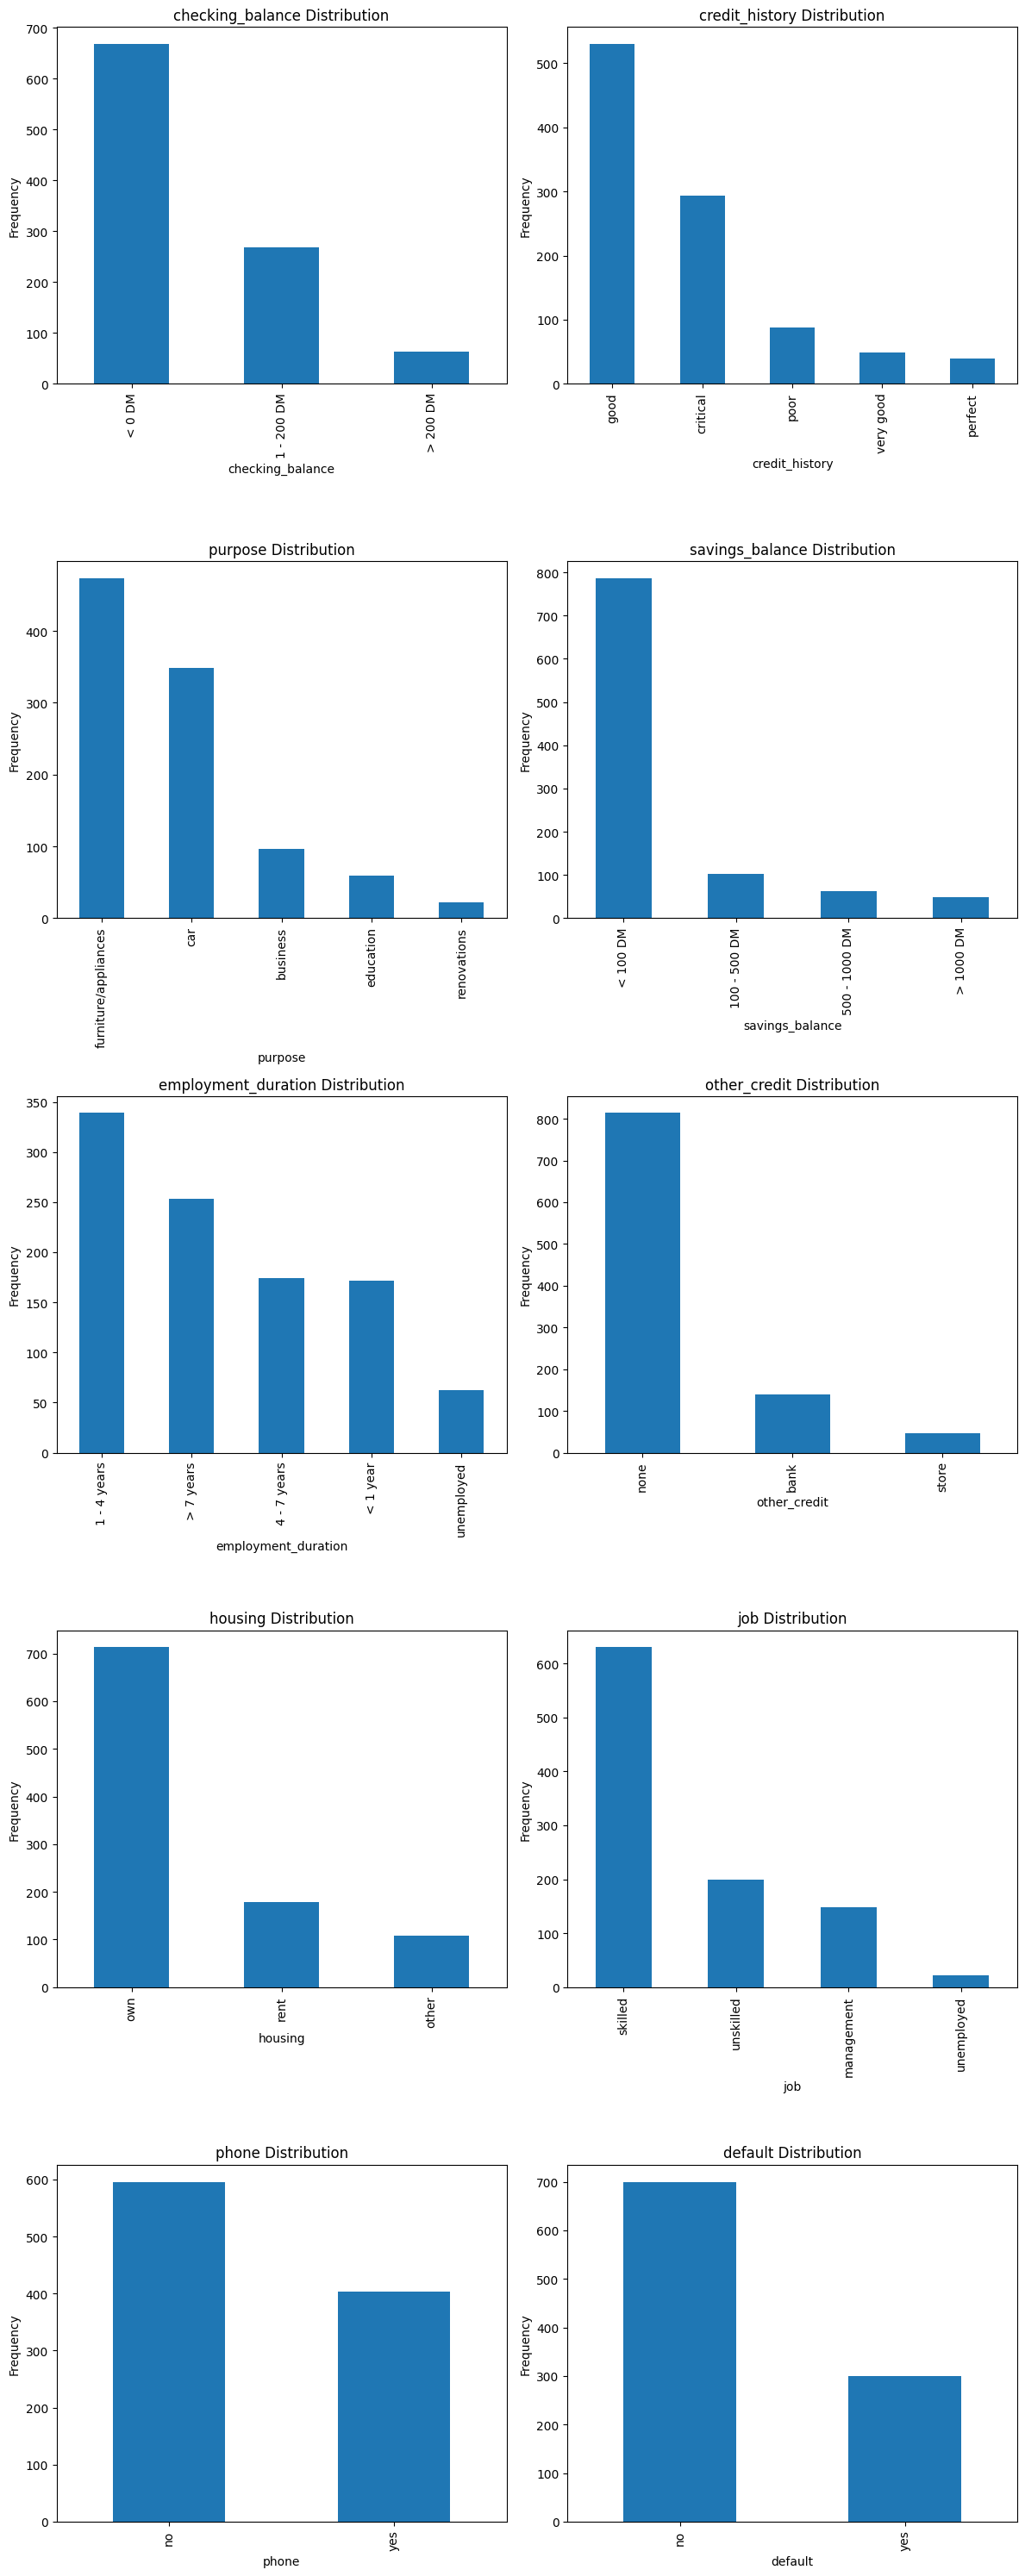

In [ ]:
feature_distribution(credit_data,categorical_cols)

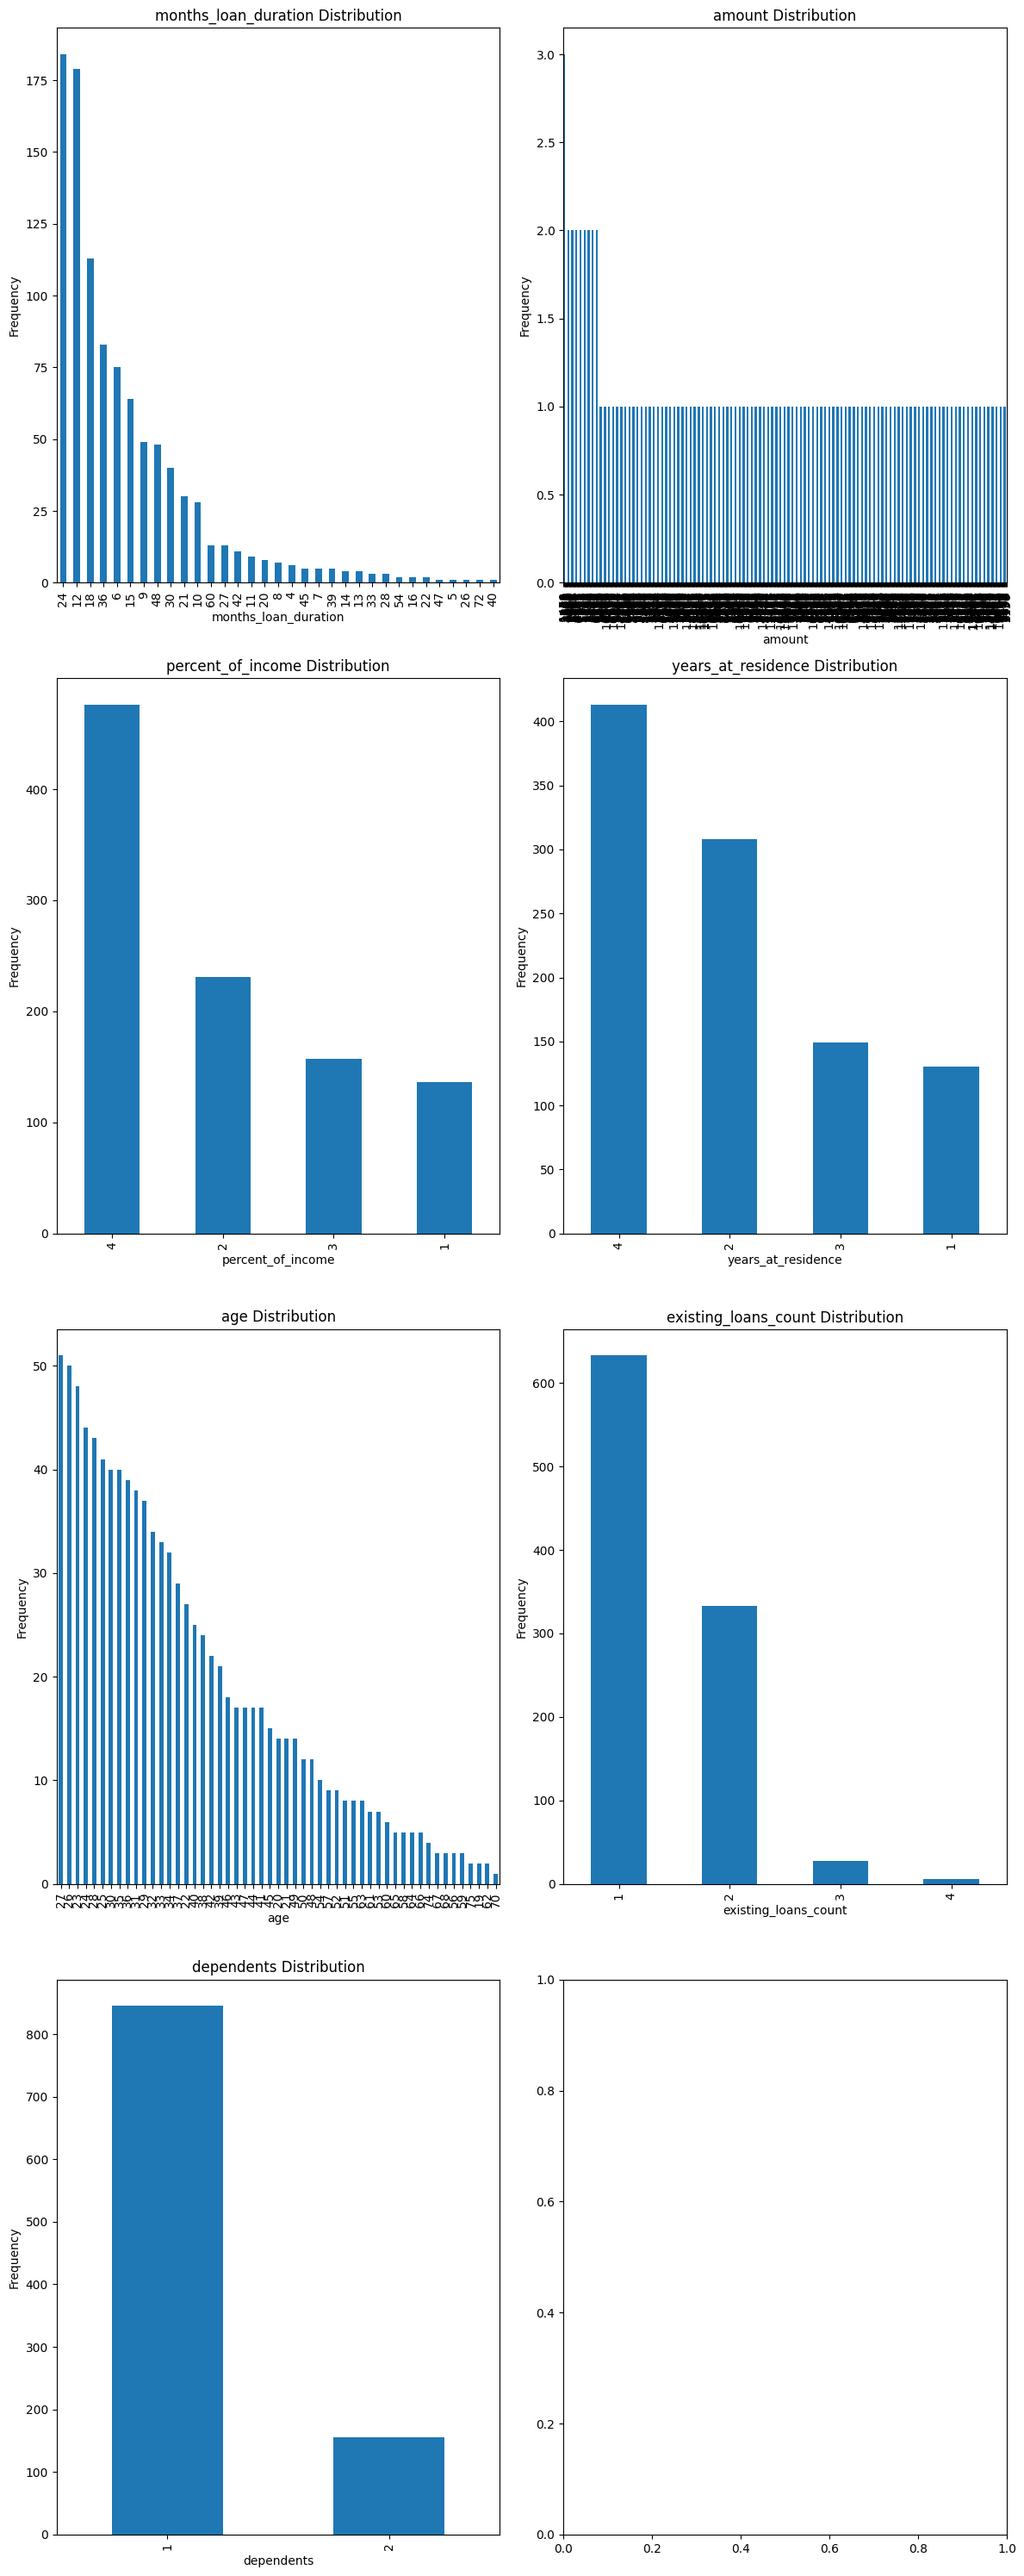

In [ ]:
feature_distribution(credit_data,numerical_cols)

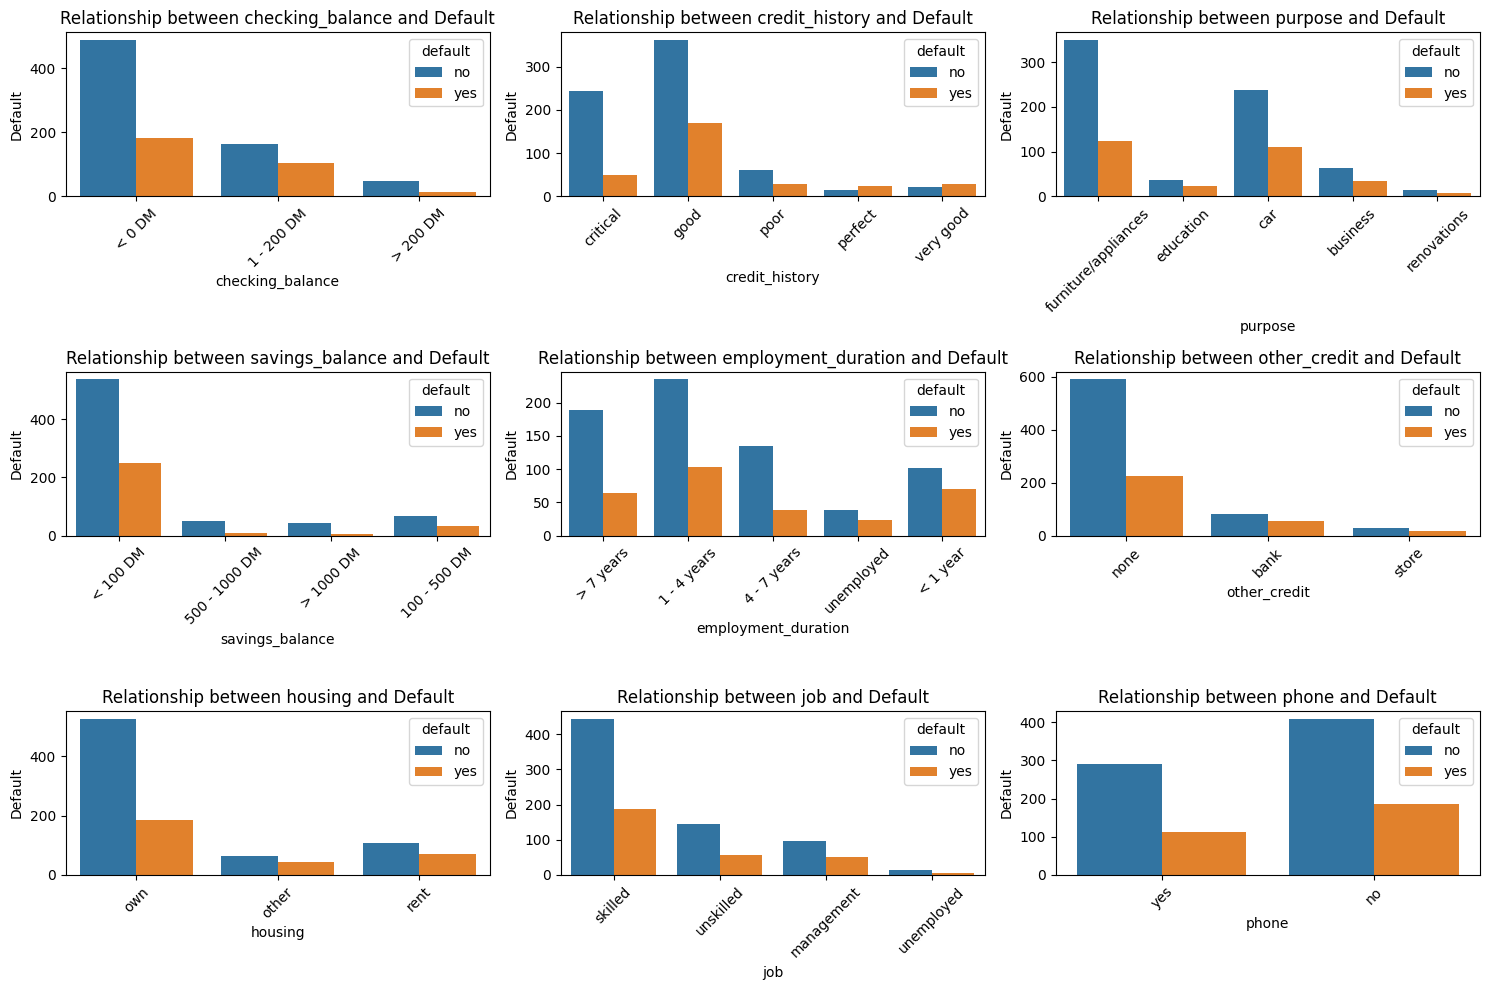

In [ ]:
# Relation betweem categorical predictor to target variable default
categoricalColumns = ['checking_balance', 'credit_history', 'purpose', 'savings_balance',
       'employment_duration', 'other_credit', 'housing', 'job', 'phone',
       ]
categorical_predictors_to_target(credit_data, categoricalColumns)

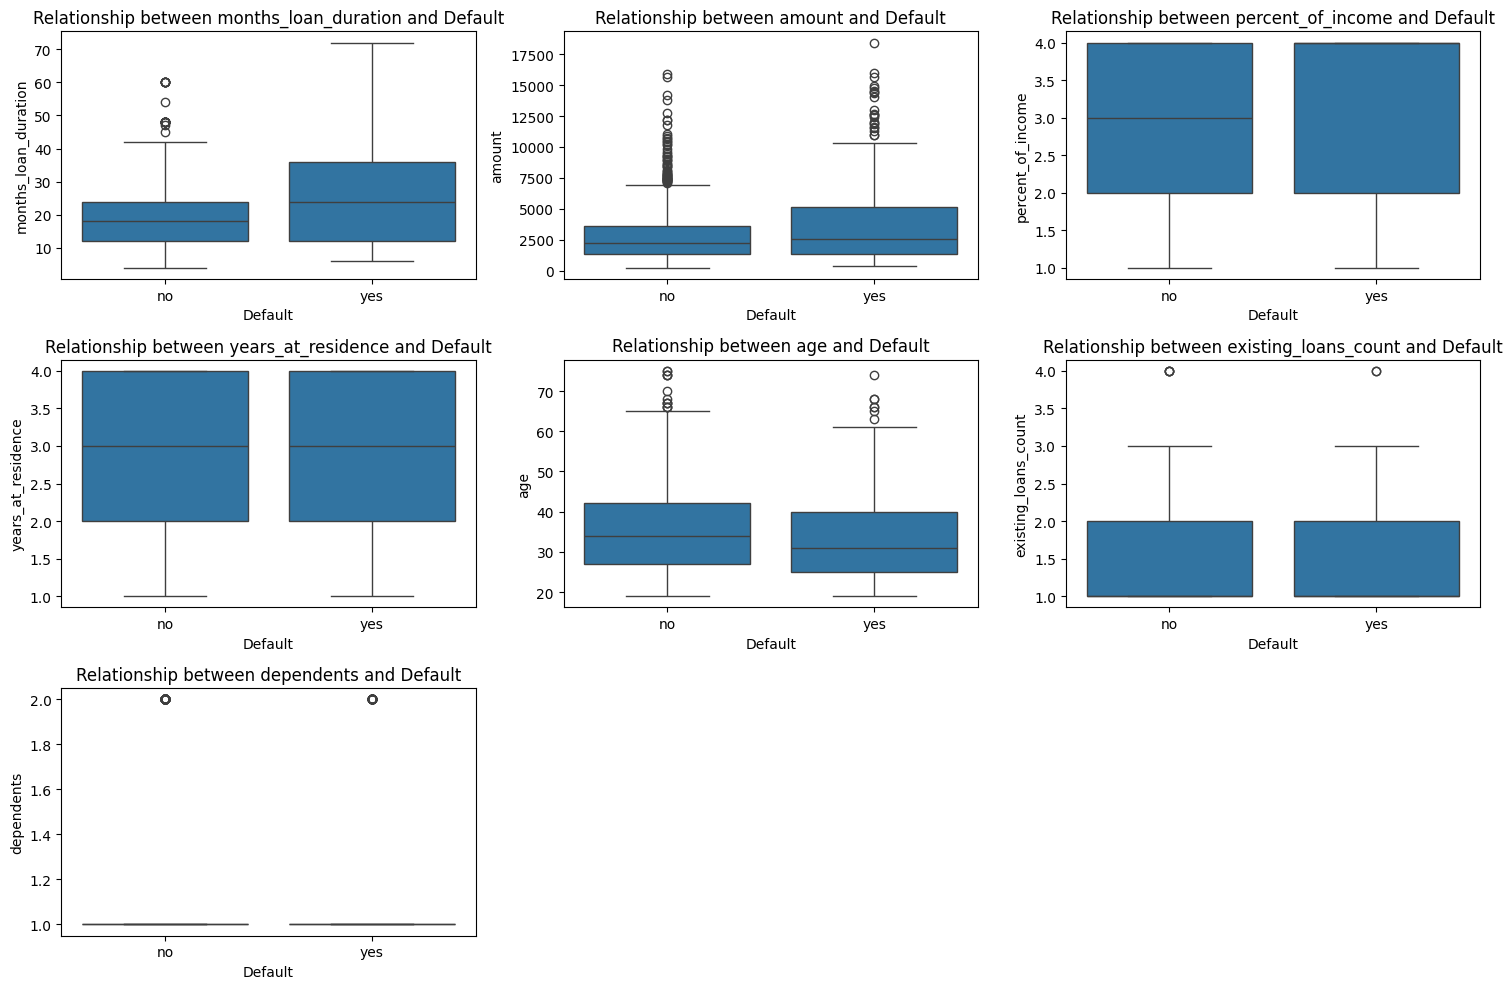

In [ ]:
numericalColumns = ['months_loan_duration','amount','percent_of_income','years_at_residence',
 'age','existing_loans_count','dependents']
# Relation betweem numeric predictor to target variable default
numeric_predictors_to_target(credit_data, numericalColumns)

Here are the key takeaways from the box plots:

1. Loan Duration (Months): Longer loan durations are associated with a higher likelihood of default. This suggests that borrowers with extended repayment periods may be at greater risk.

2. Loan Amount: While there is a slight increase in loan amounts among those who default, the overall distributions are similar. However, higher amounts exhibit more outliers in the default category, indicating that larger loans could potentially increase the risk of default.

3. Existing Loans Count: The number of existing loans is similar across default and non-default cases, suggesting that the number of existing loans does not strongly influence the likelihood of default.

These interpretations highlight that loan duration and, to a lesser extent, loan amount might be significant indicators of default risk, while the number of existing loans appears to be less relevant.

##### Encoding Categorical Variables

In [ ]:
# Perform Label/Ordinal Encoding to Convert Categorical Variables into Numerical Variables.
# List of categorical columns and their respective categories
categorical_columns = ['checking_balance', 'savings_balance', 'employment_duration', 'job']
categories_list = [
    ['< 0 DM', '1 - 200 DM', '> 200 DM'],
    ['< 100 DM', '100 - 500 DM', '500 - 1000 DM', '> 1000 DM'],
    ['unemployed', '< 1 year', '1 - 4 years', '4 - 7 years', '> 7 years'],
    ['unemployed', 'unskilled', 'skilled', 'management']
]

# Define the columns for label encoding
columns_to_encode = ['credit_history','purpose','other_credit','housing','phone']

# Custom function for label encoding with pandas
def label_encode(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

In [ ]:
# Drop original categorical columns without encoding and target from X
drop_columns = ['default']

# Split data
X = credit_data.drop(drop_columns, axis=1)
y = credit_data['default'].map({'no': 0, 'yes': 1})

In [ ]:
credit_data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,< 100 DM,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,< 0 DM,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


**Splitting the data into train/test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(700, 16) (300, 16)


In [ ]:
def drop_original_columns(X, columns):
    """Drops specified columns from a DataFrame."""
    return X.drop(columns=columns)

**Performing Label and Ordinal Encoding to the Categorical Variables**

In [ ]:
# Preprocessing pipeline with custom transformer
transformer = ColumnTransformer(transformers= [
    ('ordinal', OrdinalEncoder(categories=categories_list), categorical_columns),
    ('drop_original', FunctionTransformer(drop_original_columns, kw_args={'columns': categorical_columns}), categorical_columns),  # New step to drop original columns
    ('label', FunctionTransformer(label_encode, kw_args={'columns': columns_to_encode}), columns_to_encode),
    ('FeatureScaling', StandardScaler(), numerical_cols)
], remainder = 'passthrough')

# Set output to pandas DataFrame
transformer.set_output(transform='pandas')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinal',
                                 OrdinalEncoder(categories=[['< 0 DM',
                                                             '1 - 200 DM',
                                                             '> 200 DM'],
                                                            ['< 100 DM',
                                                             '100 - 500 DM',
                                                             '500 - 1000 DM',
                                                             '> 1000 DM'],
                                                            ['unemployed',
                                                             '< 1 year',
                                                             '1 - 4 years',
                                                             '4 - 7 years',
                                                             '> 7 years'],
                                                            ['unemployed',
                                                             'unskilled',
                                                             'skilled',
                                                             'management']]),
                                 ['checking_balance', 'savings_balance',
                                  'employment_duration', 'job']),
                                ('drop...
                                 FunctionTransformer(func=<function label_encode at 0x7fe1276bdbd0>,
                                                     kw_args={'columns': ['credit_history',
                                                                          'purpose',
                                                                          'other_credit',
                                                                          'housing',
                                                                          'phone']}),
                                 ['credit_history', 'purpose', 'other_credit',
                                  'housing', 'phone']),
                                ('FeatureScaling', StandardScaler(),
                                 Index(['months_loan_duration', 'amount', 'percent_of_income',
       'years_at_residence', 'age', 'existing_loans_count', 'dependents'],
      dtype='object'))])

**Apply the transformer to the data**

In [ ]:
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(700, 16) (300, 16)


## Building the Models

In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=1),
    'Random Forest': RandomForestClassifier(random_state=1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=1),
    "Bagging": BaggingClassifier(random_state=1),
    'XGBoost': XGBClassifier(random_state=1, eval_metric="logloss"),
    'SVM': SVC(probability=True),
}

### Training and Evaluating Models.

#### Logistic Regression

Training performance of Logistic Regression:
   Accuracy    Recall  Precision      F1
0  0.718571  0.239234   0.568182  0.3367
*************************************
Test performance of Logistic Regression:
   Accuracy    Recall  Precision      F1
0  0.718571  0.239234   0.568182  0.3367
*************************************
*************************************


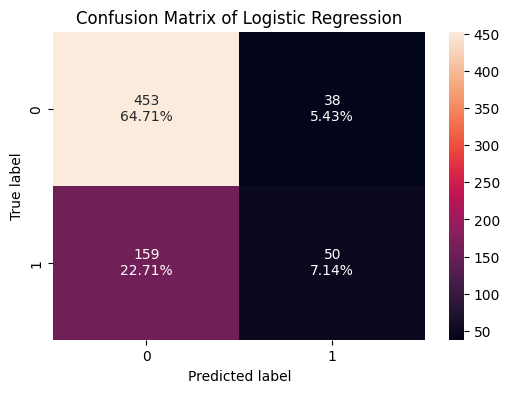

In [ ]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
# Calculating different metrics on train and test set
lr_train_performance = model_performance_classification_sklearn(lr, X_train, y_train)
lr_test_performance = model_performance_classification_sklearn(lr, X_test, y_test)
print(f'Training performance of Logistic Regression:')
print(lr_train_performance)
print("*************************************")
print(f'Test performance of Logistic Regression:')
print(lr_train_performance)
print("*************************************")


# creating confusion matrix
confusion_matrix_sklearnn('Logistic Regression', lr, X_train, y_train)
print("*************************************")

#### Random Forest Classifier

Training performance of Random Forest Classifier:
   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
*************************************
Test performance of Random Forest Classifier:
   Accuracy   Recall  Precision        F1
0  0.733333  0.32967   0.612245  0.428571
*************************************
*************************************


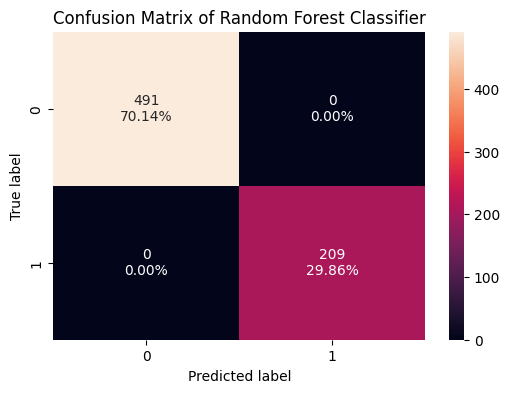

In [ ]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
# Calculating different metrics on train and test set
rf_train_performance = model_performance_classification_sklearn(rf, X_train, y_train)
rf_test_performance = model_performance_classification_sklearn(rf, X_test, y_test)
print(f'Training performance of Random Forest Classifier:')
print(rf_train_performance)
print("*************************************")
print(f'Test performance of Random Forest Classifier:')
print(rf_test_performance)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn('Random Forest Classifier', rf, X_train, y_train)
print("*************************************")

#### GradientBoostingClassifier

Training performance of GradientBoosting Classifier:
   Accuracy    Recall  Precision    F1
0      0.88  0.636364   0.943262  0.76
*************************************
Test performance of GradientBoosting Classifier:
   Accuracy   Recall  Precision        F1
0  0.703333  0.21978   0.526316  0.310078
*************************************
*************************************


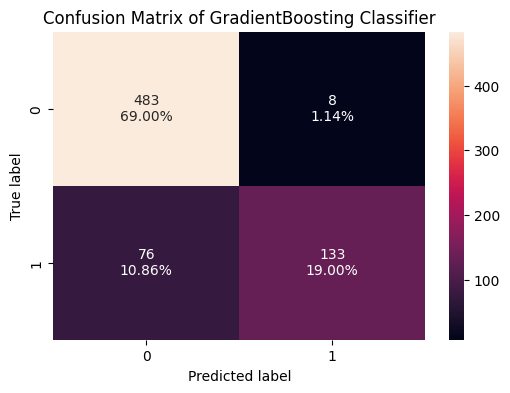

In [ ]:
gbmc = GradientBoostingClassifier(random_state=1)
gbmc.fit(X_train, y_train)
y_pred = gbmc.predict(X_test)

# Calculating different metrics on train and test set
gbm_train_performance = model_performance_classification_sklearn(gbmc, X_train, y_train)
gbm_test_performance = model_performance_classification_sklearn(gbmc, X_test, y_test)
print(f'Training performance of GradientBoosting Classifier:')
print(gbm_train_performance)
print("*************************************")
print(f'Test performance of GradientBoosting Classifier:')
print(gbm_test_performance)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn('GradientBoosting Classifier', gbmc, X_train, y_train)
print("*************************************")

#### BaggingClassifier

Training performance of Bagging Classifier:
   Accuracy    Recall  Precision        F1
0  0.981429  0.937799        1.0  0.967901
*************************************
Test performance of Bagging Classifier:
   Accuracy    Recall  Precision        F1
0       0.7  0.241758   0.511628  0.328358
*************************************
*************************************


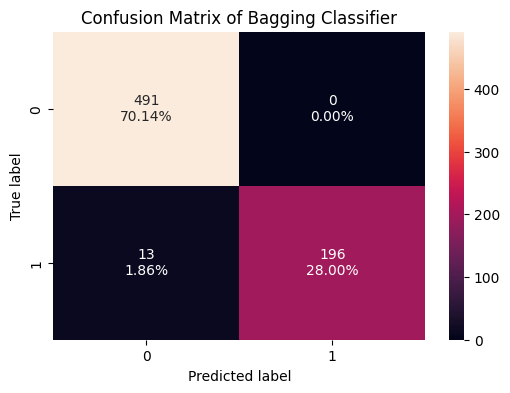

In [ ]:
bc = BaggingClassifier(random_state=1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)

# Calculating different metrics on train and test set
bc_train_performance = model_performance_classification_sklearn(bc, X_train, y_train)
bc_test_performance = model_performance_classification_sklearn(bc, X_test, y_test)
print(f'Training performance of Bagging Classifier:')
print(bc_train_performance)
print("*************************************")
print(f'Test performance of Bagging Classifier:')
print(bc_test_performance)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn('Bagging Classifier', bc, X_train, y_train)
print("*************************************")

#### XGBClassifier

Training performance:
   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
*************************************
Test performance:
   Accuracy    Recall  Precision        F1
0  0.693333  0.340659   0.492063  0.402597
*************************************
*************************************


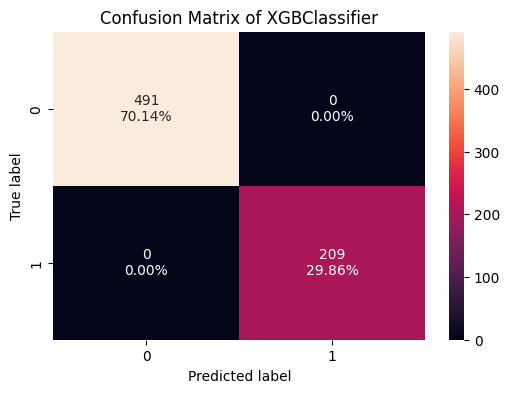

In [ ]:
xgbc = XGBClassifier(random_state=1, eval_metric="logloss")
xgbc.fit(X_train, y_train)
y_pred_xgbc = xgbc.predict(X_test)

# Calculating different metrics on train and test set
xgbc_train = model_performance_classification_sklearn(xgbc, X_train, y_train)
xgbc_test = model_performance_classification_sklearn(xgbc, X_test, y_test)

print("Training performance:")
print(xgbc_train)
print("*************************************")
print("Test performance:")
print(xgbc_test)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn("XGBClassifier", xgbc, X_train, y_train)
print("*************************************")

#### SVM

Training performance:
   Accuracy    Recall  Precision        F1
0  0.742857  0.148325   0.939394  0.256198
*************************************
Test performance:
   Accuracy    Recall  Precision    F1
0      0.72  0.087912   0.888889  0.16
*************************************
*************************************


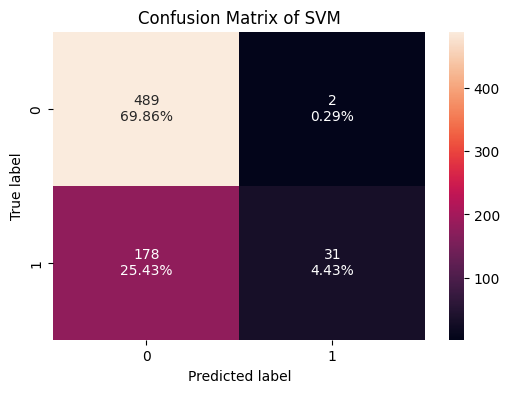

In [ ]:
svc = SVC(probability=True)
svc.fit(X_train, y_train)

y_pred_svc = svc.predict(X_test)

# Calculating different metrics on train and test set
svc_train = model_performance_classification_sklearn(svc, X_train, y_train)
svc_test = model_performance_classification_sklearn(svc, X_test, y_test)

print("Training performance:")
print(svc_train)
print("*************************************")
print("Test performance:")
print(svc_test)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn("SVM", svc, X_train, y_train)
print("*************************************")

### HyperParameter Tuning of Models

#### GBM

In [ ]:
# Apply HyperParameter Tuning to GBM.
gbm = GradientBoostingClassifier(random_state=1)
#hyperparameters
grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "max_depth": [1,2,3],
}
gbm_report = tune_boosting_hyperparameters(gbm, grid, X_train, X_test, y_train, y_test)

Best Parameters: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 30}
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       209
           1       0.45      0.38      0.41        91

    accuracy                           0.67       300
   macro avg       0.60      0.59      0.59       300
weighted avg       0.66      0.67      0.66       300



Training performance:
   Accuracy    Recall  Precision        F1
0      0.95  0.870813   0.957895  0.912281
*************************************
Test performance:
   Accuracy    Recall  Precision        F1
0  0.683333  0.351648   0.470588  0.402516
*************************************


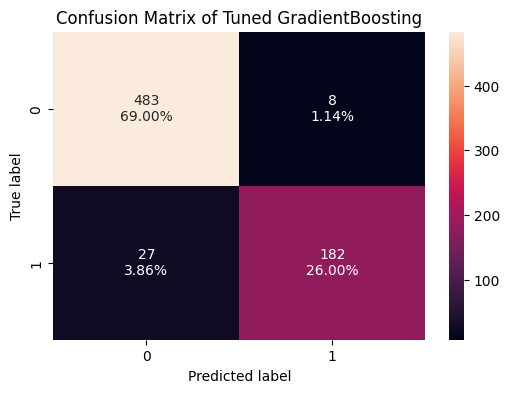

In [ ]:
# building model with best parameters
gbm_tuned1 = GradientBoostingClassifier(
    n_estimators=30,
    learning_rate=1,
    max_depth=3,
)

# Fit the model on training data
gbm_tuned1.fit(X_train, y_train)

# Calculating different metrics on train set
GBM_grid_train = model_performance_classification_sklearn(gbm_tuned1, X_train, y_train)
GBM_grid_test = model_performance_classification_sklearn(gbm_tuned1, X_test, y_test)
print("Training performance:")
print(GBM_grid_train)
print("*************************************")
print("Test performance:")
print(GBM_grid_test)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn('Tuned GradientBoosting', gbm_tuned1, X_train, y_train)

#### XGB

Applying Hyper Parameter Tuning to XGBoost

In [ ]:
# Apply HyperParameter Tuning to GBM.
xgb = XGBClassifier(random_state=1, eval_metric="logloss")

#hyperparameters
grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "max_depth": [1,2,3],
}
xgb_report = tune_boosting_hyperparameters(xgb, grid, X_train, X_test, y_train, y_test)

Best Parameters: {'learning_rate': 1, 'max_depth': 2, 'n_estimators': 80}
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       209
           1       0.47      0.32      0.38        91

    accuracy                           0.68       300
   macro avg       0.60      0.58      0.58       300
weighted avg       0.66      0.68      0.66       300



Training performance:
   Accuracy    Recall  Precision        F1
0  0.934286  0.837321   0.935829  0.883838
*************************************
Test performance:
   Accuracy    Recall  Precision        F1
0  0.683333  0.318681   0.467742  0.379085
*************************************


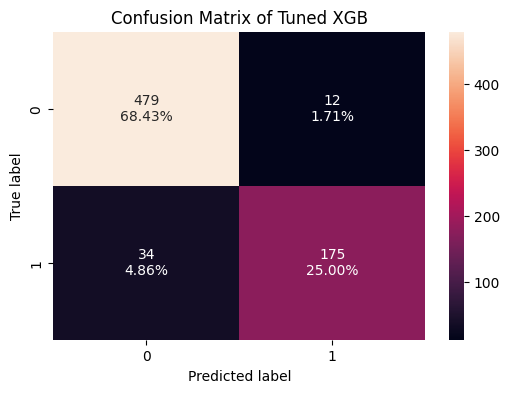

In [ ]:
# building model with best parameters
xgb_tuned1 = XGBClassifier(
    n_estimators=80,
    learning_rate=1,
    max_depth=2,
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

# Calculating different metrics on train set
XGB_grid_train = model_performance_classification_sklearn(xgb_tuned1, X_train, y_train)
XGB_grid_test = model_performance_classification_sklearn(xgb_tuned1, X_test, y_test)
print("Training performance:")
print(XGB_grid_train)
print("*************************************")
print("Test performance:")
print(XGB_grid_test)
print("*************************************")

# creating confusion matrix
confusion_matrix_sklearnn('Tuned XGB', xgb_tuned1, X_train, y_train)

### Voting Classifier

In [ ]:
model_list = list(models.items())

# Create a Voting Classifier
voting_classifier = VotingClassifier(estimators= model_list, voting='soft')

# Train the Voting Classifier
voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(random_state=1)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=1)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=1)),
                             ('Bagging', BaggingClassifier(random_state=1)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsa...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                             ('SVM', SVC(probability=True))],
                 voting='soft')

Training performance:
   Accuracy    Recall  Precision        F1
0  0.971429  0.904306        1.0  0.949749

*************************************
Test performance:
   Accuracy    Recall  Precision        F1
0  0.726667  0.252747   0.621622  0.359375

*************************************


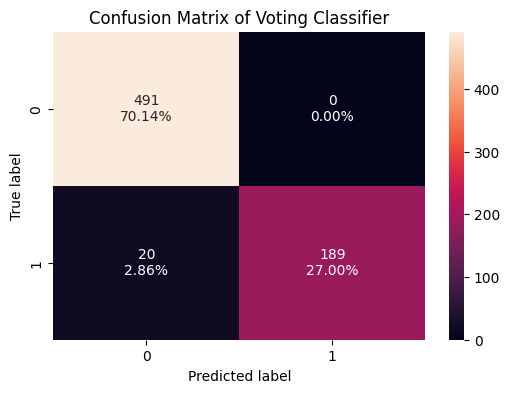

In [ ]:
# Calculating different metrics on train and test set
Vote_train = model_performance_classification_sklearn(voting_classifier, X_train, y_train)
Vote_test = model_performance_classification_sklearn(voting_classifier, X_test, y_test)
print("Training performance:")
print(Vote_train)
print("\n*************************************")
print("Test performance:")
print(Vote_test)
print("\n*************************************")
# creating confusion matrix
confusion_matrix_sklearnn("Voting Classifier", voting_classifier, X_train, y_train)

In [ ]:
# Create a Voting Classifier
voting_hard_classifier = VotingClassifier(estimators= model_list, voting='hard')

# Train the Voting Classifier
voting_hard_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(random_state=1)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=1)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=1)),
                             ('Bagging', BaggingClassifier(random_state=1)),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsa...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=1, ...)),
                             ('SVM', SVC(probability=True))])

Training performance:
   Accuracy    Recall  Precision        F1
0  0.971429  0.904306        1.0  0.949749

*************************************
Test performance:
   Accuracy    Recall  Precision        F1
0  0.726667  0.252747   0.621622  0.359375

*************************************


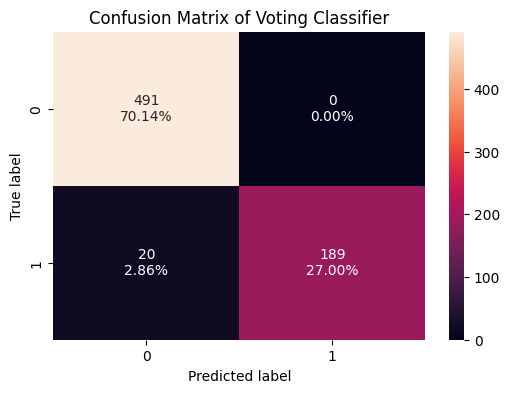

In [ ]:
# Calculating different metrics on train and test set
Vote_hard_train = model_performance_classification_sklearn(voting_classifier, X_train, y_train)
Vote_hard_test = model_performance_classification_sklearn(voting_classifier, X_test, y_test)
print("Training performance:")
print(Vote_train)
print("\n*************************************")
print("Test performance:")
print(Vote_test)
print("\n*************************************")
# creating confusion matrix
confusion_matrix_sklearnn("Voting Classifier", voting_classifier, X_train, y_train)

#  Comparing all models

In [ ]:
# testing performance comparison

models_test_comparison = pd.concat([
    lr_test_performance.T,
    rf_test_performance.T,
    bc_test_performance.T,
    gbm_test_performance.T,
    GBM_grid_test.T,
    xgbc_test.T,
    XGB_grid_test.T,
    svc_test.T,
    Vote_test.T,
    Vote_hard_test.T
],
axis=1)
models_test_comparison.columns = ["Logistic Regression", "Random Forest", "Bagging", "Gradient Boosting", "Gradient Boosting (Grid)", "XGBoost", "XGBoost (Grid)", "SVC",
                                  "Voting Classifier (Soft)", "Voting Classifier (Hard)"]
print('Model Test Comparison:')
models_test_comparison.T

Model Test Comparison:


,Accuracy,Recall,Precision,F1
Logistic Regression,0.710000,0.164835,0.576923,0.256410
Random Forest,0.733333,0.329670,0.612245,0.428571
Bagging,0.700000,0.241758,0.511628,0.328358
Gradient Boosting,0.703333,0.219780,0.526316,0.310078
Gradient Boosting (Grid),0.683333,0.351648,0.470588,0.402516
XGBoost,0.693333,0.340659,0.492063,0.402597
XGBoost (Grid),0.683333,0.318681,0.467742,0.379085
SVC,0.720000,0.087912,0.888889,0.160000
Voting Classifier (Soft),0.726667,0.252747,0.621622,0.359375
Voting Classifier (Hard),0.726667,0.252747,0.621622,0.359375


In [ ]:
# training performance comparison

models_train_comparison = pd.concat([
    lr_train_performance.T,
    rf_train_performance.T,
    bc_train_performance.T,
    gbm_train_performance.T,
    GBM_grid_train.T,
    xgbc_train.T,
    XGB_grid_train.T,
    svc_train.T,
    Vote_train.T,
    Vote_hard_train.T
],
axis=1)
models_train_comparison.columns = ["Logistic Regression", "Random Forest", "Bagging", "Gradient Boosting", "Gradient Boosting (Grid)", "XGBoost", "XGBoost (Grid)", "SVC",
                                  "Voting Classifier (Soft)", "Voting Classifier (Hard)"]
print('Model Train Comparison:')
models_train_comparison.T

Model Train Comparison:


,Accuracy,Recall,Precision,F1
Logistic Regression,0.718571,0.239234,0.568182,0.336700
Random Forest,1.000000,1.000000,1.000000,1.000000
Bagging,0.981429,0.937799,1.000000,0.967901
Gradient Boosting,0.880000,0.636364,0.943262,0.760000
Gradient Boosting (Grid),0.950000,0.870813,0.957895,0.912281
XGBoost,1.000000,1.000000,1.000000,1.000000
XGBoost (Grid),0.934286,0.837321,0.935829,0.883838
SVC,0.742857,0.148325,0.939394,0.256198
Voting Classifier (Soft),0.971429,0.904306,1.000000,0.949749
Voting Classifier (Hard),0.971429,0.904306,1.000000,0.949749


In [ ]:
# Normalize each metric column (0 to 1 scale) so that higher is better for all metrics
normalized_metrics = models_test_comparison.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Calculate a weighted score for each model
# You can adjust the weights according to the importance of each metric
weights = {
    "Accuracy": 0.25,
    "Recall": 0.25,
    "Precision": 0.25,
    "F1": 0.25
}

# Compute the weighted score for each model
weighted_scores = np.dot(normalized_metrics.T, [weights["Accuracy"], weights["Recall"], weights["Precision"], weights["F1"]])

# Create a DataFrame to display the scores
model_scores = pd.DataFrame({
    "Model": models_test_comparison.columns,
    "Score": weighted_scores
})

# Sort the models by the score (highest score is best)
model_scores = model_scores.sort_values(by="Score", ascending=False).reset_index(drop=True)

print("Model Rankings Based on Aggregate Scores:")
print(model_scores)

# Identify the best model
best_model = model_scores.iloc[0]
print(f"\nThe best model is: {best_model['Model']} with a score of {best_model['Score']:.4f}")

Model Rankings Based on Aggregate Scores:
                      Model     Score
0             Random Forest  0.814946
1  Voting Classifier (Soft)  0.649851
2  Voting Classifier (Hard)  0.649851
3                   XGBoost  0.529843
4  Gradient Boosting (Grid)  0.477436
5                       SVC  0.433333
6            XGBoost (Grid)  0.422685
7                   Bagging  0.411935
8         Gradient Boosting  0.399470
9       Logistic Regression  0.360805

The best model is: Random Forest with a score of 0.8149


RandomForest and Gradient Boosting (Grid) are the best model based on the provided metrics. Here's why:

Testing Performance: They have the highest F1-scores (0.485, 0.428571) on the testing set, indicating a good balance between precision and recall. This makes it more reliable in handling imbalanced classes.

Generalization: It generalizes well from training to testing, maintaining a good balance across all metrics, which is crucial for real-world application.